In [45]:
import pandas as pd
import spacy

import utils_data as ud
import preprocess as prep

from pandas.io.json import json_normalize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter

%matplotlib inline
%load_ext autoreload
%autoreload 2
%timeit

pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
reviews = pd.read_hdf("data/mal_reviews.hdf5", "table")

In [3]:
reviews.iloc[0]

mal_id                                                 10030
reviews    [{'reviewer': {'scores': {'story': 10, 'charac...
title                                    Bakuman. 2nd Season
Name: 0, dtype: object

In [4]:
reviews.iloc[0]["reviews"][0]

{'content': "Overall I give Bakuman season 2 a 10! Maybe I'm just biased, but to me it deserves it.\r\nIf you enjoyed Bakuman Season 1 then you MUST See Bakuman Season 2, anyone who enjoyed Bakuman Season 1 as much as I should agree with my rating of 10 for season 2.\r\nSome anime's are good, and their second seasons are just a drag, but with Bakuman, season 1 was great and season 2 is even better! The story continues from season 1, even after season 1 I wanted to see what happened next and I still feel the same now in season 2 at episode 6.\r\nStory: 10\r\nUnlikemany anime's Bakuman is realistic. It shows many hardships throughout the story that the characters go through, just when things get better a new tragedy occurs. It really says something about real life, the realistic plot is one of Bakuman's greatest traits and it helps as get into the story even more when we feel the hardships as the characters feel them.\\n\\n\r\nCharacters: 10\\n\r\nAlmost all the characters in Bakuman are

In [5]:
reviews_list = []
for index, row in reviews.iterrows():
    df = json_normalize(row["reviews"])
    df.rename(columns={"mal_id": "review_id"}, inplace=True)
    df["mal_id"] = row["mal_id"]
    df["title"] = row["title"]
    reviews_list.append(df)

In [6]:
reviews = pd.concat(reviews_list)

In [7]:
reviews.columns

Index(['content', 'date', 'helpful_count', 'review_id',
       'reviewer.episodes_seen', 'reviewer.image_url',
       'reviewer.scores.animation', 'reviewer.scores.character',
       'reviewer.scores.enjoyment', 'reviewer.scores.overall',
       'reviewer.scores.sound', 'reviewer.scores.story', 'reviewer.url',
       'reviewer.username', 'url', 'mal_id', 'title'],
      dtype='object')

In [8]:
reviews.drop(labels=["reviewer.image_url", "reviewer.url", "url"], axis=1, inplace=True)

In [9]:
# Reorganize
mal_id = reviews["mal_id"]
title = reviews["title"]
review_id = reviews["review_id"]
reviewer = reviews["reviewer.username"]
reviews.drop(labels=["mal_id", "title", "review_id", "reviewer.username"], axis=1, inplace=True)
reviews.insert(0, "mal_id", mal_id)
reviews.insert(1, "title", title)
reviews.insert(2, "review_id", review_id)
reviews.insert(3, "reviewer", reviewer)

In [10]:
reviews.describe()

,mal_id,review_id,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
count,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000
mean,18180.403023,180208.666397,28.664311,18.309572,7.502582,6.908696,7.204100,7.314270,7.376096,6.620076
std,12069.788246,89600.772751,102.697117,68.034048,2.392581,2.902133,2.918456,2.284119,2.422250,2.766798
min,15.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7054.000000,107340.000000,3.000000,12.000000,7.000000,5.000000,6.000000,6.000000,6.000000,5.000000
50%,16706.000000,200539.000000,6.000000,12.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000
75%,30727.000000,254712.000000,16.000000,23.000000,9.000000,9.000000,10.000000,9.000000,9.000000,9.000000
max,37991.000000,307885.000000,4091.000000,9001.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [11]:
reviews.isna().sum()

mal_id                       0
title                        0
review_id                    0
reviewer                     0
content                      0
date                         0
helpful_count                0
reviewer.episodes_seen       0
reviewer.scores.animation    0
reviewer.scores.character    0
reviewer.scores.enjoyment    0
reviewer.scores.overall      0
reviewer.scores.sound        0
reviewer.scores.story        0
dtype: int64

In [12]:
reviews["date"] = pd.to_datetime(reviews["date"], infer_datetime_format=True)

I'm mainly interested in `content`, though `helpful_count` and `reviewers.episodes_seen` can be helpful.

In [37]:
# look at word distributions
word_map = Counter()
for i, (index, row) in enumerate(reviews.iterrows()):
    if i % 1000 == 0:
        print(i)
    for word in row['content'].split(" "):
        word = word.lower()
        if word not in word_map:
            word_map[word] = 1
        else:
            word_map[word] += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


In [38]:
word_map.most_common(100)

[('the', 2546622),
 ('and', 1244474),
 ('to', 1121009),
 ('of', 1112938),
 ('a', 1093299),
 ('is', 830536),
 ('i', 644665),
 ('that', 616704),
 ('in', 609862),
 ('it', 600604),
 ('this', 474106),
 ('but', 368692),
 ('for', 360676),
 ('with', 350459),
 ('as', 349299),
 ('was', 309219),
 ('you', 295873),
 ('are', 285363),
 ('not', 239818),
 ('anime', 236064),
 ('be', 227042),
 ('', 208560),
 ('they', 207669),
 ('on', 203547),
 ('have', 203102),
 ('like', 197789),
 ('characters', 177071),
 ('just', 174568),
 ('at', 165855),
 ('so', 164388),
 ('all', 161726),
 ('show', 161314),
 ('one', 159764),
 ('an', 158608),
 ('really', 155221),
 ('from', 153377),
 ('or', 153291),
 ('more', 147679),
 ('some', 143498),
 ('if', 139597),
 ('about', 139327),
 ('story', 136232),
 ('he', 130079),
 ("it's", 129535),
 ('character', 129105),
 ('her', 127673),
 ('what', 127407),
 ('has', 127265),
 ('there', 125158),
 ('very', 124910),
 ('their', 123973),
 ('by', 118238),
 ('his', 115287),
 ('my', 113762),
 ('who

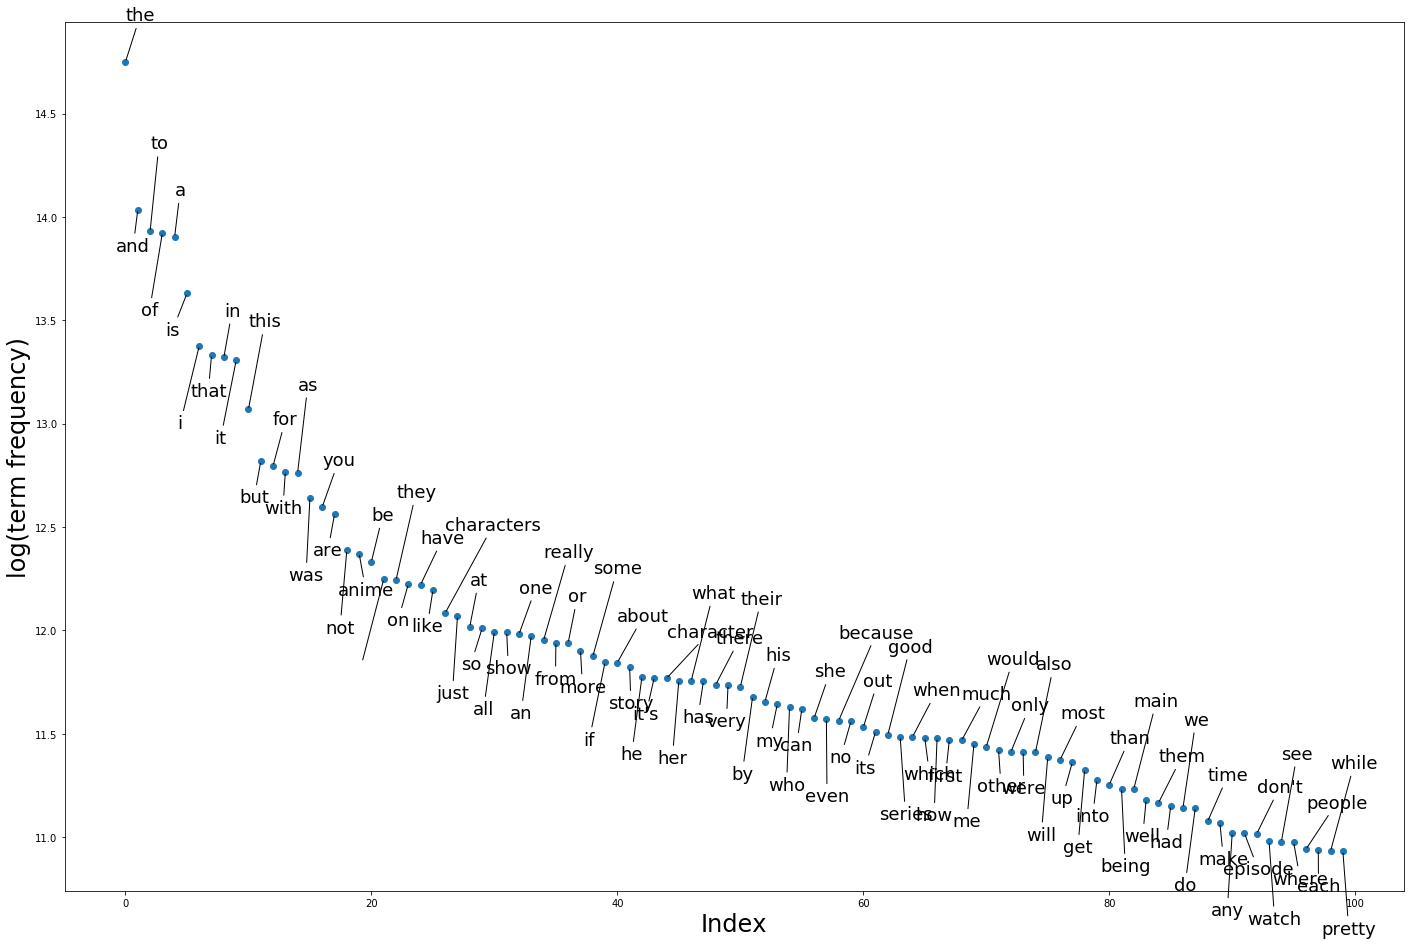

In [41]:
ud.plot_normalized_word_counts(word_map, 100)

I'm not going to remove any stop words, since we may lose some important information.

Also remember to split data into training and testing, before training document vectors.

In [262]:
reviews["review_id"].value_counts()

266242    2
236312    2
281314    2
27366     2
28611     2
58103     2
292800    2
215685    2
114617    2
119569    2
202668    2
32997     2
213827    2
242461    2
214950    2
39727     2
144173    2
49971     2
190354    2
168761    2
179004    2
172863    2
152289    2
238303    2
184279    2
205519    2
196655    2
18290     2
172059    2
94853     2
         ..
299445    1
172467    1
305586    1
229847    1
276960    1
287275    1
29055     1
29225     1
89027     1
30920     1
252444    1
123419    1
14654     1
90635     1
225801    1
197127    1
201221    1
250389    1
135653    1
57851     1
190970    1
295415    1
139997    1
168437    1
307697    1
279023    1
156139    1
291305    1
2534      1
208698    1
Name: review_id, Length: 63789, dtype: int64

In [264]:
reviews.loc[reviews["review_id"] == 236312]

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
0,31339,Drifters,236312,Stark700,Drifters is the type of show that you’ll quick...,2016-12-23 20:32:00+00:00,145,12,8,9,8,8,7,7
20,31339,Drifters,236312,Stark700,Drifters is the type of show that you’ll quick...,2016-12-23 20:32:00+00:00,145,12,8,9,8,8,7,7


So I collected duplicate reviews. I'll need to get rid of those.

I also found a review that is in spanish... this means the corpus may contain reviews in different languages (e.g. chinese, japanese, etc)

In [267]:
reviews.drop_duplicates(inplace=True)

In [512]:
reviews.shape # consider using 13789 for testing (which is ~80:20 -- more of 79:21)

(63789, 14)

In [285]:
reviews.memory_usage(deep=True).sum()

335419343

In [44]:
nlp = spacy.load("en_core_web_lg")

In [487]:
sample_text = []
scores = []
lengths = []
for i, (index, row) in enumerate(reviews.iterrows()):
    if i == 2500:
        break
    else:
        sample = prep.tokenize_text(row["content"], nlp)
        sample_text.append(sample)

In [488]:
docs = [TaggedDocument([word for word in doc.text.split(" ")], [i]) for i, doc in enumerate(sample_text)]

In [490]:
model = Doc2Vec(docs, vector_size=50, min_count=2, 
                workers=4, epochs=20, dm=1, hs=1)

In [537]:
query = "mirai nikki and yanderes"
v = model.infer_vector([x for x in query.split(" ")])

In [538]:
rankings = model.docvecs.most_similar([v], topn=100)

In [539]:
for i in range(10):
    print("-" * 35 + " " + str(i) + " " + "-" * 35)
    print(" ".join(docs[rankings[i][0]].words))

----------------------------------- 0 -----------------------------------
this series is probably of my favorite slice of life animes ever the humor is sporadic but ai n't random the characters are cute and quirky but not stupid the music is catchy in a good way overall this anime is a must watch for those who love anything cute and funny 
----------------------------------- 1 -----------------------------------
this anime had the greatest potential of all to become something better than yet another steaming pile of crap that 's stuck in the otaku loop it had the useful athletic and otherwise awesome male protagonist voice my a mr bust out in a fit of laughter that 's right i 'm it had the team behind the nanoha series it had colors all up in dey art and animation and it had some stealth panty shots but then as if the lebron james hate plague spread from cleveland or its basketball team and managed to revitalize the otaku base 's hatred against those better than themselves it pulls dog